In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

Load data - from raw version

torch.float32 torch.Size([36, 3, 49, 49])
torch.float32 torch.Size([36, 1])
torch.float32 torch.Size([36, 1])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0627, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])


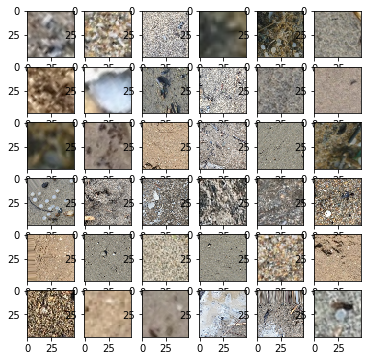

In [35]:
class RawDataset(Dataset):
    def __init__(self):
        s = 49
        self.imgin = np.fromfile("images/data_in.raw", dtype=np.uint8)
        self.imgin = self.imgin.reshape((len(self.imgin)//(3*s*s), 3, s, s))
        self.imgout = np.fromfile("images/data_out.raw", dtype=np.uint8)
        self.imgweight = np.fromfile("images/data_weight.raw", dtype=np.float32)
        self.size = s

    def __len__(self):
        nin = self.imgin.shape[0]
        nout = len(self.imgout)
        assert nin == nout
        return nin

    def __getitem__(self, i):
        return [
            self.imgin[i].astype(np.float32) / 255.0,
            self.imgout[i:i+1].astype(np.float32) / 255.0,
            self.imgweight[i:i+1]
        ]

dataset = RawDataset()
for imgin, imgout, imgweight in DataLoader(
    dataset,
    batch_size=36,
    shuffle=True
):
    print(imgin.dtype, imgin.shape)
    print(imgout.dtype, imgout.shape)
    print(imgweight.dtype, imgweight.shape)
    n = int(imgin.shape[0]**0.5)

    imgout = imgout.reshape((n, n))
    print(imgout)

    imgin = np.einsum('acij->aijc', imgin.numpy())

    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(imgin[i])

    plt.show()
    break

Model

In [36]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        n = 4
        model = [
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 33x33
            nn.Conv2d(3, n, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        for _ in range(10):
            model += [
                nn.Conv2d(n, n, 3, 1, 0, bias=False),
                nn.ZeroPad2d(-1),
                nn.BatchNorm2d(n),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        model += [
            # 3 x 5x5
            nn.Conv2d(n, 1, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            # 1 x 1x1
            nn.Sigmoid()
        ]
        self.main = nn.Sequential(*model)
    
    def forward(self, x):
        return self.main(x)

model = Model()
print(model)

Model(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (12): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(4, 4, kerne

Training

In [42]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005, betas=(0.9, 0.999))


lossFun = torch.nn.BCELoss
flatten = torch.nn.Flatten()

print("ADAM")
count = 0
for epoch in range(1, 5+1):
    print("Epoch", epoch)
    for nin, nout, nweight in dataloader:
        optimizer.zero_grad()
        output = flatten(model(nin))
        nweight = torch.ones_like(nweight)
        loss = lossFun(nweight)(output, nout)
        loss.backward()
        optimizer.step()
        count += 1
        if count % 200 == 0:
            print("Iteration {} - loss = {}".format(count, loss.item()))

ADAM
Epoch 1
Iteration 200 - loss = 0.07795019447803497
Iteration 400 - loss = 0.06165023893117905
Iteration 600 - loss = 0.18256708979606628
Iteration 800 - loss = 0.200905442237854
Iteration 1000 - loss = 0.03742576017975807
Iteration 1200 - loss = 0.13157609105110168
Iteration 1400 - loss = 0.14376911520957947
Iteration 1600 - loss = 0.2305593341588974
Epoch 2
Iteration 1800 - loss = 0.04013006016612053
Iteration 2000 - loss = 0.04439106956124306
Iteration 2200 - loss = 0.05491490662097931
Iteration 2400 - loss = 0.044942617416381836
Iteration 2600 - loss = 0.10448144376277924
Iteration 2800 - loss = 0.07656615972518921
Iteration 3000 - loss = 0.08997426927089691
Iteration 3200 - loss = 0.04015139490365982
Epoch 3
Iteration 3400 - loss = 0.07338496297597885
Iteration 3600 - loss = 0.12595519423484802
Iteration 3800 - loss = 0.052374087274074554
Iteration 4000 - loss = 0.06275586783885956
Iteration 4200 - loss = 0.049280643463134766
Iteration 4400 - loss = 0.13510483503341675
Iterati

Calculate running mean and variance

In [43]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True
))

for nin, nout, nweight in dataloader:
    with torch.no_grad():
        output = flatten(model(nin))
        loss = lossFun(nweight)(output, nout)
        print(loss)

tensor(0.0356)


Export

In [44]:
import os
os.system("rm weights/*")

param_i = 0
bn_i = 0
bns = []
for param in model.parameters():
    data = param.data
    shape = '_'.join(map(str, data.shape))
    if len(data.shape) == 1:
        name = "bn{:02d}{}".format(bn_i//2, bn_i%2)
        bns.append((name, data))
        bn_i += 1
        continue
    name = "w{:02d}_{}".format(param_i, shape)
    data.numpy().astype(np.float32).tofile("weights/"+name+".bin")
    param_i += 1

bn_i = 0
for layer in model.main:
    if layer.__class__.__name__ != "BatchNorm2d":
        continue
    layer.track_running_stats = False  # freeze
    mu = layer.running_mean
    var = layer.running_var
    name = "bn{:02d}2".format(bn_i)
    bns.append((name, mu))
    name = "bn{:02d}3".format(bn_i)
    bns.append((name, var))
    bn_i += 1

bns.sort()
for name, data in bns:
    s = '[' + ', '.join(map(str, data.numpy())) + ']'
    print(f"{name}: {s},")

bn000: [1.0553219, 0.6662044, 1.3500087],
bn001: [-0.03506492, -1.36198, -0.43027607],
bn002: [0.5737029, 0.5316771, 0.48150685],
bn003: [0.031771094, 0.029481629, 0.030051813],
bn010: [0.8632038, 1.4280099, 1.6053091, 0.9949949],
bn011: [-0.38696748, 0.05335361, 0.17830865, 0.15888634],
bn012: [-0.3848454, -0.54188156, -1.0507636, -3.4307811],
bn013: [1.8826396, 1.5993352, 3.04873, 1.8786678],
bn020: [1.3899636, 1.3980222, 0.9582938, 1.0326794],
bn021: [0.72399235, 0.3963475, -0.49146163, -0.6247471],
bn022: [-1.7305624, -2.7668872, 1.4792061, -3.4997947],
bn023: [51.588856, 21.110723, 7.296432, 28.127878],
bn030: [0.79778093, 0.72352344, 1.6784978, 1.1256533],
bn031: [-0.5717044, -0.6942276, -0.11048854, -0.19933328],
bn032: [-0.759722, 2.4502249, -0.72403276, -0.14573431],
bn033: [2.9636898, 9.032732, 3.483016, 2.6600304],
bn040: [1.0820913, 0.986699, 0.8878645, 1.5641184],
bn041: [-0.5685234, -0.10396792, -0.3410908, -0.3387838],
bn042: [-0.40971038, -0.49515846, -0.87796056, -3.84